In [1]:
#TODO rm
%reload_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pyhf
import cabinetry
import redist
import matplotlib.pyplot as plt

np.random.seed(11)

# Reinterpetation with **redist**

![LOGO](fig/logo.svg)

**redist** performs histogram reweighting based on differences in kinematic distributions. It is built to operate in combination with [pyhf](https://pyhf.readthedocs.io).

## A simple analysis with `pyhf`

`pyhf` ( = HistFactory in python) has become a copmmon analysis tool for statistical inference.

### Simulate some data

We want to measure the decay $A \to B C D$, which has a single imaginary kinematic degree of freedom $z$. 

We expect the **signal** to be normally distributed according to the PDF
$$
p(z) = \mathcal{N}(z|\mu=4, \sigma=1.5)
$$
and our **background** to be distributed according to the PDF
$$
p(z) = \frac{1}{5}e^{-z/5}.
$$

We expect 10 times more background than signal, so we simulate

- 10k signal events,
- 100k background events.

In [2]:
mean = 4.

bkg_samples_gen = sp.stats.expon.rvs(loc=0, scale=5., size=100000)
sig_samples_gen = sp.stats.norm.rvs( loc=mean, scale=1.5, size= 10000)

Next we need to simulate our detector. It accepts 10% of events at random and smears our kinematic variable $z$ normally, with $\sigma=1$.

In [3]:
def detector(x):
    acceptance = np.random.rand(*np.shape(x)) > 0.9
    resolution = sp.stats.norm.rvs(x)
    return resolution[acceptance], x[acceptance]

bkg_samples_detector, bkg_samples = detector(bkg_samples_gen)
sig_samples_detector, sig_samples = detector(sig_samples_gen)

We decide that the reconstructed kinematic variable, after considering detector effects $x \sim \varepsilon(x|z)$ distinguishes signal and background distributions well for $0<x<10$ and chose it as a fitting variable.

In [4]:
bins = np.arange(0,10)

# We only want to keep the events with physical values for z
sig_samples_detector[(sig_samples < bins[0]) | (sig_samples > bins[-1])] = -1
bkg_samples_detector[(bkg_samples < bins[0]) | (bkg_samples > bins[-1])] = -1

sig_hist, _ = np.histogram(sig_samples_detector, bins=bins)
bkg_hist, _ = np.histogram(bkg_samples_detector, bins=bins)

Let's see how our detector changed the shape of our distributions.

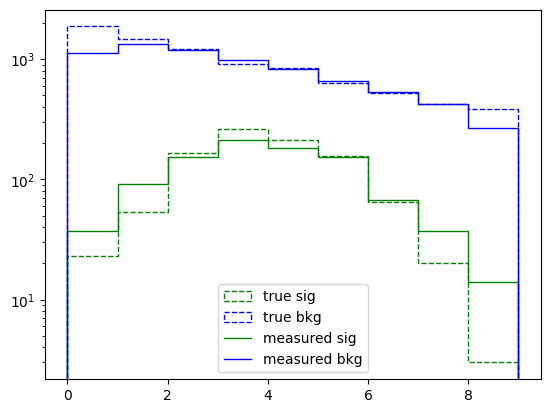

In [5]:
plt.hist(sig_samples, bins=bins, histtype='step', color='g', linestyle='dashed',label='true sig')
plt.hist(bkg_samples, bins=bins, histtype='step', color='b', linestyle='dashed',label='true bkg')

plt.stairs(sig_hist, color='g', label='measured sig')
plt.stairs(bkg_hist, color='b', label='measured bkg')

plt.yscale('log')
plt.legend()
plt.show()

### Get some data from our detector

We are now ready to look at some "real" data. 

We find that in reality, our signal is actually distributed according to the PDF
$$
p(z) = \mathcal{N}(z|\mu=5, \sigma=1.5).
$$
In addition, there are actually twice as many signal events, as expected. 

In [6]:
mean_true = 5.
scale_true = 2.

bkg_samples_data = sp.stats.expon.rvs(scale=5., size=100000)
sig_samples_data = sp.stats.norm.rvs(loc=mean_true, scale=1.5, size= 10000)

bkg_samples_data, _ = detector(bkg_samples_data)
sig_samples_data, _ = detector(sig_samples_data)

bkg_hist_data, _ = np.histogram(bkg_samples_data, bins=bins)
sig_hist_data, _ = np.histogram(sig_samples_data, bins=bins)

data = (bkg_hist_data + sig_hist_data * scale_true).tolist()


## Set up the model

We construct our statistical model and add a Poisson error for our background.

In [7]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=sig_hist.tolist(), 
    bkg=bkg_hist.tolist(), 
    bkg_uncertainty=np.sqrt(bkg_hist).tolist()
)

Let's see how all of this looks together. We use `cabinetry` for visualization here. it also calculates the correct uncertainties for us.

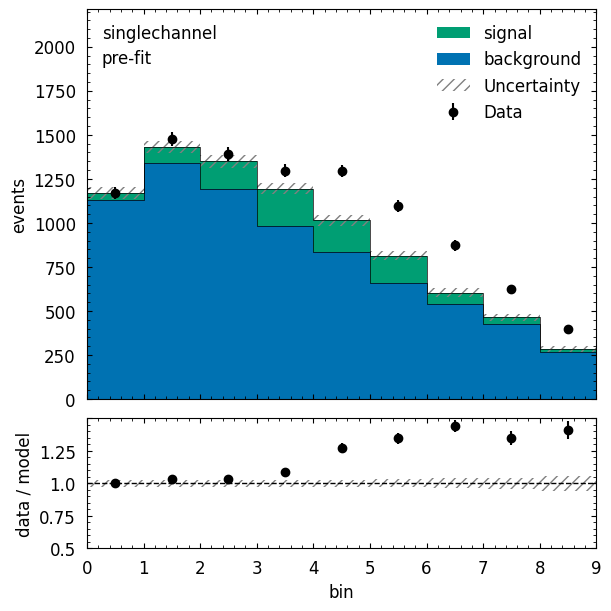

In [8]:
model_pred_postfit = cabinetry.model_utils.prediction(model)
cabinetry.visualize.data_mc(model_pred_postfit, data);

That does not look too good yet.

Maybe after fitting, things will look better?

In [9]:
fit_results = cabinetry.fit.fit(model, data + model.config.auxdata)
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")


mu: 2.260 +/- 0.123
uncorr_bkguncrt[0]: 0.981 +/- 0.021
uncorr_bkguncrt[1]: 0.976 +/- 0.020
uncorr_bkguncrt[2]: 0.944 +/- 0.022
uncorr_bkguncrt[3]: 0.933 +/- 0.026
uncorr_bkguncrt[4]: 1.025 +/- 0.029
uncorr_bkguncrt[5]: 1.052 +/- 0.033
uncorr_bkguncrt[6]: 1.150 +/- 0.036
uncorr_bkguncrt[7]: 1.123 +/- 0.038
uncorr_bkguncrt[8]: 1.174 +/- 0.048


Nice, we got the scale factor correct! 

But would you really trust a best fit result that looks like this:

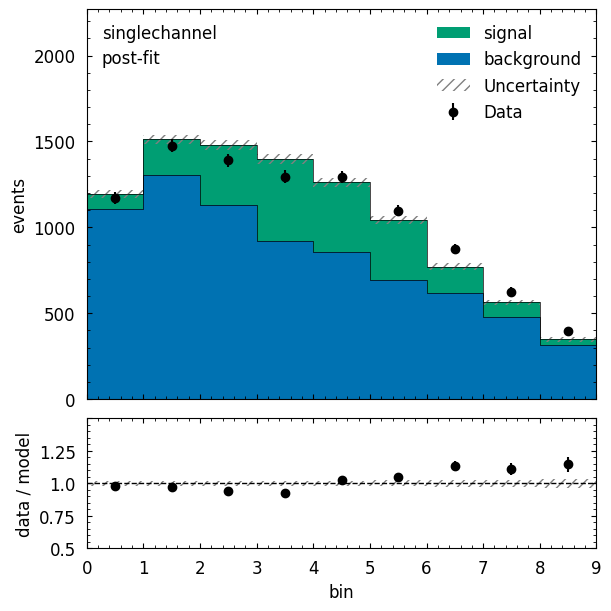

In [10]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
cabinetry.visualize.data_mc(model_pred_postfit, data);

To make things better, we decide that the signal PDF might not be the correct one. It would be great if we could leave the mean free floating here and also learn something about this parameter:
$$
p(z|m) = \mathcal{N}(z|\mu=m, \sigma=1.5).
$$

In reality there is no easy way to do this. You would have to
1. Pick an alternative value for $m$,
2. Generate new MC samples,
3. Simulate the detector response to each of the samples,
4. Redo the statistical analysis,
and repeat this until you found a good value for $m$. 

Phu...

What about a better way?

# `redist` reinterpretation method

After reconstruction you obtain a number-density $n(x)$ for all channels, in a reconstruction/fitting variable $x$. Stacking all signal and background contributions, this is what we compare to the data.

When producing MC samples, we made a choice - the theoretical prediction 
$$
    \sigma(z) = \sigma p(z)
$$
in the kinematic variable(s) $z$. Usually, this is a SM prediction, but can be any theory. 

![theory -> number density](fig/redist.drawio.svg)

The number density $n(x)$ and the theoretical prediction $\sigma(z)$ are connected via
$$
    n(x) = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma(z)
$$
where we fold the theoretical prediction with the conditional reconstruction and selection efficiency $\varepsilon(x|z)$ and scale by the corresponding luminosity $L$.

Futher, we can define the **joint number density** 
$$
n(x,z) = L ~ \varepsilon(x|z) ~ \sigma(z).
$$
Analysts can easily compute the joint number density $n_A(x,z)$ for their underlying theory with a kinematic prediction $\sigma_A(z)$ from the MC samples.


![theory -> number density](fig/redist-rw.drawio.svg)

With this object alone, we can obtain the bin yields $n_B(x)$ of an alternative prediction $\sigma_B(z)$,
$$
    n_B(x)
        = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma_B(z)
        = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma_A(z) ~ \frac{\sigma_B(z)}{\sigma_A(z)}
        = \sum_z ~ n_A(x,z) ~ w(z).
$$
Here, the weights $w(z)$ are the ratio of the bin integrated kinematic predictions. 

Let us apply this to our example!

## Null and alternative kinematics

First, let us define the theory predictions of our null hypothesis,
$$
    \sigma_{null}(z) = \mathcal{N}(z|\mu=4, \sigma=1.5).
$$

Next we define the kinematic prediction for our alternative hypothesis. We want a free floating $\mu$ parameter. In addition, based on your previous knowledge, we incorporate the scaling factor of 2 into the new model as well
$$
\sigma_{alt.}(z|m) = 2 \cdot \mathcal{N}(z|\mu=m, \sigma=1.5).
$$

(Only the relative scaling matters here.)

In [11]:
def null_dist(x):
    return sp.stats.norm.pdf(x, loc=4., scale=1.5)

def alt_dist(x, mu = 6.):
    scale = 2.
    return scale*sp.stats.norm.pdf(x, loc=mu, scale=1.5)

## Create the joint number densities

Creating the joint number density object is easy - it is just a 2d histogram.

We can make use of the `redist.modifier.map()` function to place our samples in the correct bins:

In [12]:
redist.modifier.map?

Signature:
redist.modifier.map(
    target_samples,
    kinematic_samples,
    target_bins,
    kinematic_bins,
)
Docstring:
Generate mapping distribution from samples.

Args:
    target_samples (array): Target (fitting variable) samples.
    kinematic_samples (array): Kinematic samples.
    target_bins (array): Target (fitting variable) binning.
    kinematic_bins (array): Kinematic binning.
File:      ~/micromamba/envs/pyhep/lib/python3.10/site-packages/redist/modifier.py
Type:      function


`pyhf` flattens multidimensional histograms - so do we. The kinematics can be multidimensional, and are flattened internally. For simplicity let us use the same binnig for our kinematic degree of freedom, as we used for our reconstruction variable.

In [13]:
joint_nr_dens = redist.modifier.map(sig_samples_detector, [sig_samples], bins, [bins])

## Set up the custom modifier

Next we can define the custom modifier that will reweight our histograms internally, initialized with the `redist.modifier.Modifier()`:

In [14]:
redist.modifier.Modifier?

Init signature:
redist.modifier.Modifier(
    new_pars,
    alt_dist,
    null_dist,
    map,
    bins,
    name=None,
    cutoff=None,
    weight_bound=None,
    allow_negative_weights=False,
)
Docstring:     
Modifier implementation to reweight historgram according to the ratio of 
a null and an alternative distribution. 
Init docstring:
Args:
    new_pars (dict): New parameters to parametrize the model.
    alt_dist (callable): Alternative distribution to be tested. 
    null_dist (callable): Null distribution of the nominal model.
    map (array): Joint number density matrix, binned in the analysis bins times the kinematic bins.
    bins (array): kinematic binning
    name (string, optional): Name of the custom modifier. Defaults to None.
    cutoff (tuple, optional): Kinematic cutoff values to limit the integration boundaries to a given range. Defaults to None.
    weight_bound (float, optional): Upper bound on the weight. Defaults to None.
    allow_negative_weights (bool, option

So we only need to define our new parameter $m$ in a dictionary. Your theory friend tells you $m=3.5$ is a good choice (everyone can be wrong sometimes):

In [15]:
new_params = {
    'm' :{'inits': (3.5,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
    }

cmod = redist.modifier.Modifier(new_params, alt_dist, null_dist, joint_nr_dens, [bins], name="vary_m")

## Visualization

We can visualize the kinematic predictions, including weights with `redist.plot.dists()` and the joint number density with `redist.plot.map()`.

(<Figure size 1400x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

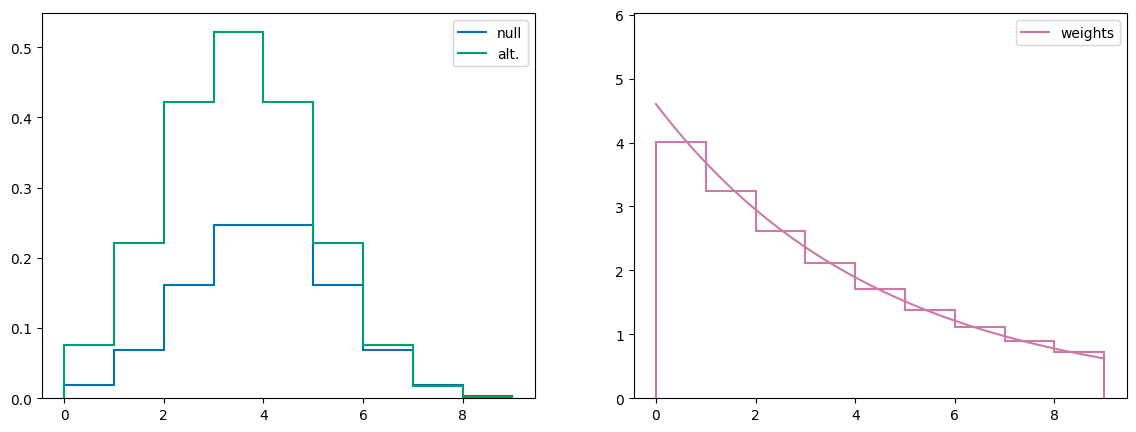

In [16]:
m = [3.5]
redist.plot.dists(cmod, m, plot_weights=True)

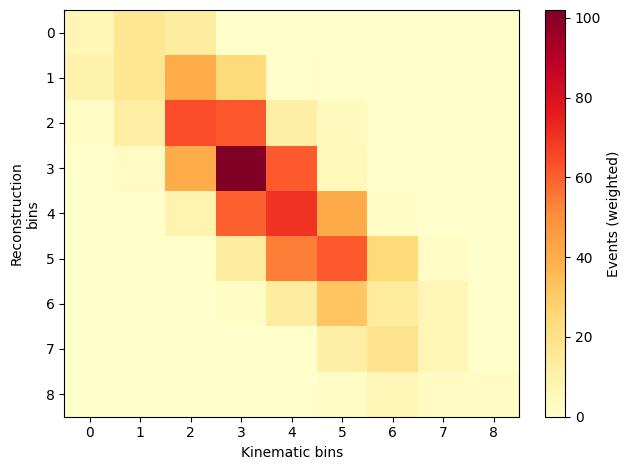

In [17]:
redist.plot.map(cmod, cmap='YlOrRd', aspect='auto');

## Adding to the statistical model

To add this to our existing `pyhf.Model`, we can use th helper function `redist.add_to_model()`:

In [18]:
redist.modifier.add_to_model?

Signature:
redist.modifier.add_to_model(
    model,
    channels,
    samples,
    modifier_set,
    modifier_specs,
    **model_kwargs,
)
Docstring:
Add a custom modifier to a pyhf model.

Args:
    model (pyhf.Model): pyhf model.
    channels (list): List of channel names to add the modifier to.
    samples (list): List of sample names to add the modifier to.
    modifier_set (pyhf.modifier.ModifierSet): Pyhf modifier set.
    modifier_specs (dict): Modifier specifications.
    model_kwargs (dict): Additional model arguments.
    
Returns:
    pyhf.Model: Model with the custom modifier added.
File:      ~/micromamba/envs/pyhep/lib/python3.10/site-packages/redist/modifier.py
Type:      function


In [20]:
custom_mod = {
                "name": "signal_vary_m",
                "type": "vary_m", # the name of the custom modifier, provided above 
                "data":
                    {
                        "expr": "vary_m_weight_fn", # the name of the custom function assigned in global namespace = modifier.name + '_weight_fn'
                    }
              }

model = redist.modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)

Let us have a look at the model parameters now:

In [21]:
model.config.par_names

['m',
 'mu',
 'uncorr_bkguncrt[0]',
 'uncorr_bkguncrt[1]',
 'uncorr_bkguncrt[2]',
 'uncorr_bkguncrt[3]',
 'uncorr_bkguncrt[4]',
 'uncorr_bkguncrt[5]',
 'uncorr_bkguncrt[6]',
 'uncorr_bkguncrt[7]',
 'uncorr_bkguncrt[8]']

## Fit the parameters

We can fit for $m$ now:

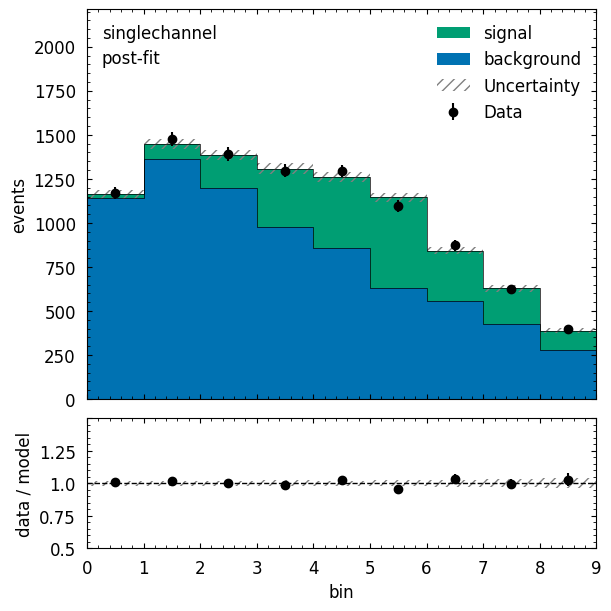

In [22]:
fit_results= cabinetry.fit.fit(model, data + model.config.auxdata)
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data)

In [23]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

m: 5.081 +/- 0.123
mu: 1.135 +/- 0.059
uncorr_bkguncrt[0]: 1.007 +/- 0.021
uncorr_bkguncrt[1]: 1.019 +/- 0.020
uncorr_bkguncrt[2]: 1.003 +/- 0.023
uncorr_bkguncrt[3]: 0.991 +/- 0.027
uncorr_bkguncrt[4]: 1.028 +/- 0.030
uncorr_bkguncrt[5]: 0.959 +/- 0.033
uncorr_bkguncrt[6]: 1.036 +/- 0.037
uncorr_bkguncrt[7]: 0.993 +/- 0.040
uncorr_bkguncrt[8]: 1.030 +/- 0.052


WOW, we managed to actually find the correct value for $m$ AND $\mu$ -- and a much better fit. 

# Not shown today

- Correlated parameters
- Combination of models

# Summary

# Bonus: Posterior estimation with Bayesian `pyhf`

In [24]:
from bayesian_pyhf import infer
import pymc as pm
import arviz as az
import corner

In [25]:
# unconstr_priors = {
#     'mu': {'type': 'Uniform_Unconstrained', 'lower': [0.], 'upper': [10.]},
#     'm' : {'type': 'Uniform_Unconstrained', 'lower': [0.], 'upper': [10.]}
# }

# n_draws = 5000

# with infer.model(model, unconstr_priors, data):
#     post_data = pm.sample(draws=n_draws, chains=4, cores=4)

# post_data.to_json( f'post_data.json')

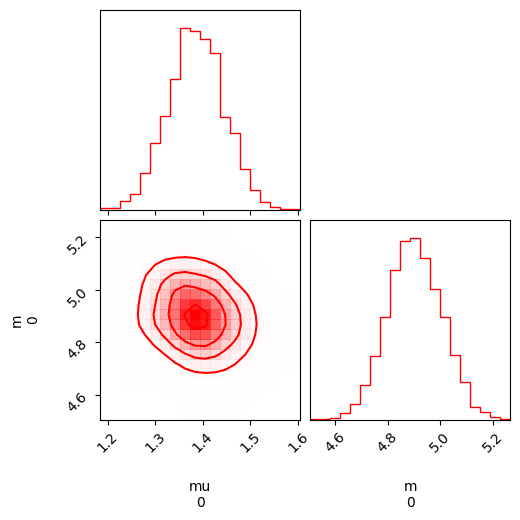

In [26]:
post_data = az.from_json('post_data.json')
corner.corner(
    post_data.posterior, 
    var_names=['mu', 'm'], 
    smooth=1, 
    color='r', 
    plot_datapoints=False
    );